In [226]:
##### imports

import requests
import statsmodels.api as sm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
scaler = MinMaxScaler()

In [227]:
##### API CAll from KEY

def extract_api_call(sample_key):
    # Split key by "."
    key_list = sample_key.split(".")
    # Extract FlowRef
    flowRef = key_list[0]
    # Extract key 
    key = sample_key[len(key_list[0])+1:]
    # Build call string
    # API Part of URL
    api_part_generic = "https://api.statistiken.bundesbank.de/rest/data/"
    api_part_specific = flowRef+"/"+key
    api_call = api_part_generic + api_part_specific
    return api_call

In [228]:
##### Function that takes in the api-call and performs a request and stores the data in a response_json

def auto_response_saver(api_call):
    #Define the header
    headers = {'accept': 'application/vnd.sdmx.data+json;version=1.0.0',}
    # Define parameters
    params = {'detail': 'full',}
    # Define full-sub
    full_response = '?detail=full'
    # Create full call
    full_call = api_call + full_response
    # Get the actual response
    response = requests.get(full_call, params=params, headers=headers,)
    # As json
    response_list = response.json()
    return(response_list)

In [229]:
##### Take Response and return DF

def extract_response(Response, ColName):
    Response_Numbers = []
    VarKey = list(Response["data"]["dataSets"][0]["series"].keys())[0]

    for key in Response["data"]["dataSets"][0]["series"][VarKey]["observations"]:
        Response_Numbers.append(Response["data"]["dataSets"][0]["series"][VarKey]["observations"][key][0])

    Response_Numbers_PD = pd.DataFrame(Response_Numbers, columns = [ColName])    

    # General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
    Response_Timestamp = []

    for element in Response["data"]["structure"]["dimensions"]["observation"][0]["values"]:
        Response_Timestamp.append(element["id"])

    Response_Timestamp_PD = pd.DataFrame(Response_Timestamp, columns = ["time"])

    Response_DF = pd.concat([Response_Timestamp_PD,Response_Numbers_PD],axis=1).set_index("time")
    
    return Response_DF

In [230]:
##### Function, that takes in a KEY and a "Name" that then 
##### builds the api call, fetches the data, extracts the data from the response and returns dataframes separately

def BBK2PD(KEY, ColName):
    Output = extract_response(auto_response_saver(extract_api_call(KEY)), ColName)
    return Output

In [231]:
##### Function for plotting ACF and PACF for temporal correlation analysis

def plot_acf_pacf(data):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2)

In [232]:
#####Variable Declaration

Keys_All = {
    
"Gold" : "BBEX3.M.XAU.EUR.EA.AC.C06",
"ALQ" : "BBDL1.M.DE.Y.UNE.UBA000.A0000.A01.D00.0.R00.A",
"Zinsentwicklung" : "BBK01.SUD189",
"Realzinssätze_Banken" : "BBK01.SUR106",
"EZB_Einlagenfazilität" : "BBK01.SU0200",
"HVPI" :"BBDP1.M.DE.N.HVPI.C.A00000.I15.A",
"Effektivzinsen": "BBK01.SUD131Z",
"Auftragseingang_Bau":"BBDY1.M.B30.Y.G800.R0400.A"    

}

##### Create separate varables from dict

for key, value in Keys_All.items():
    exec(f"{key} = '{value}'")

In [233]:
##### Loop through the Dict and save Variables in dataframes
for key, value in Keys_All.items():
     exec(f"{key} = BBK2PD(value, key)")
        
# Create an empty list to store the values and loop through the dictionary and extract the values 
values = []
for key in Keys_All:
    values.append(globals()[key])
#Concat all variables and join the by common index.
DTF = pd.concat(values,axis=1,join="inner")
del values
#DTF.describe()

In [234]:
##### Scale Features for better model performance

scaler.fit(DTF)
scaled_df = scaler.transform(DTF)
scaled_df = pd.DataFrame(scaled_df, columns=DTF.columns).set_index(DTF.index)

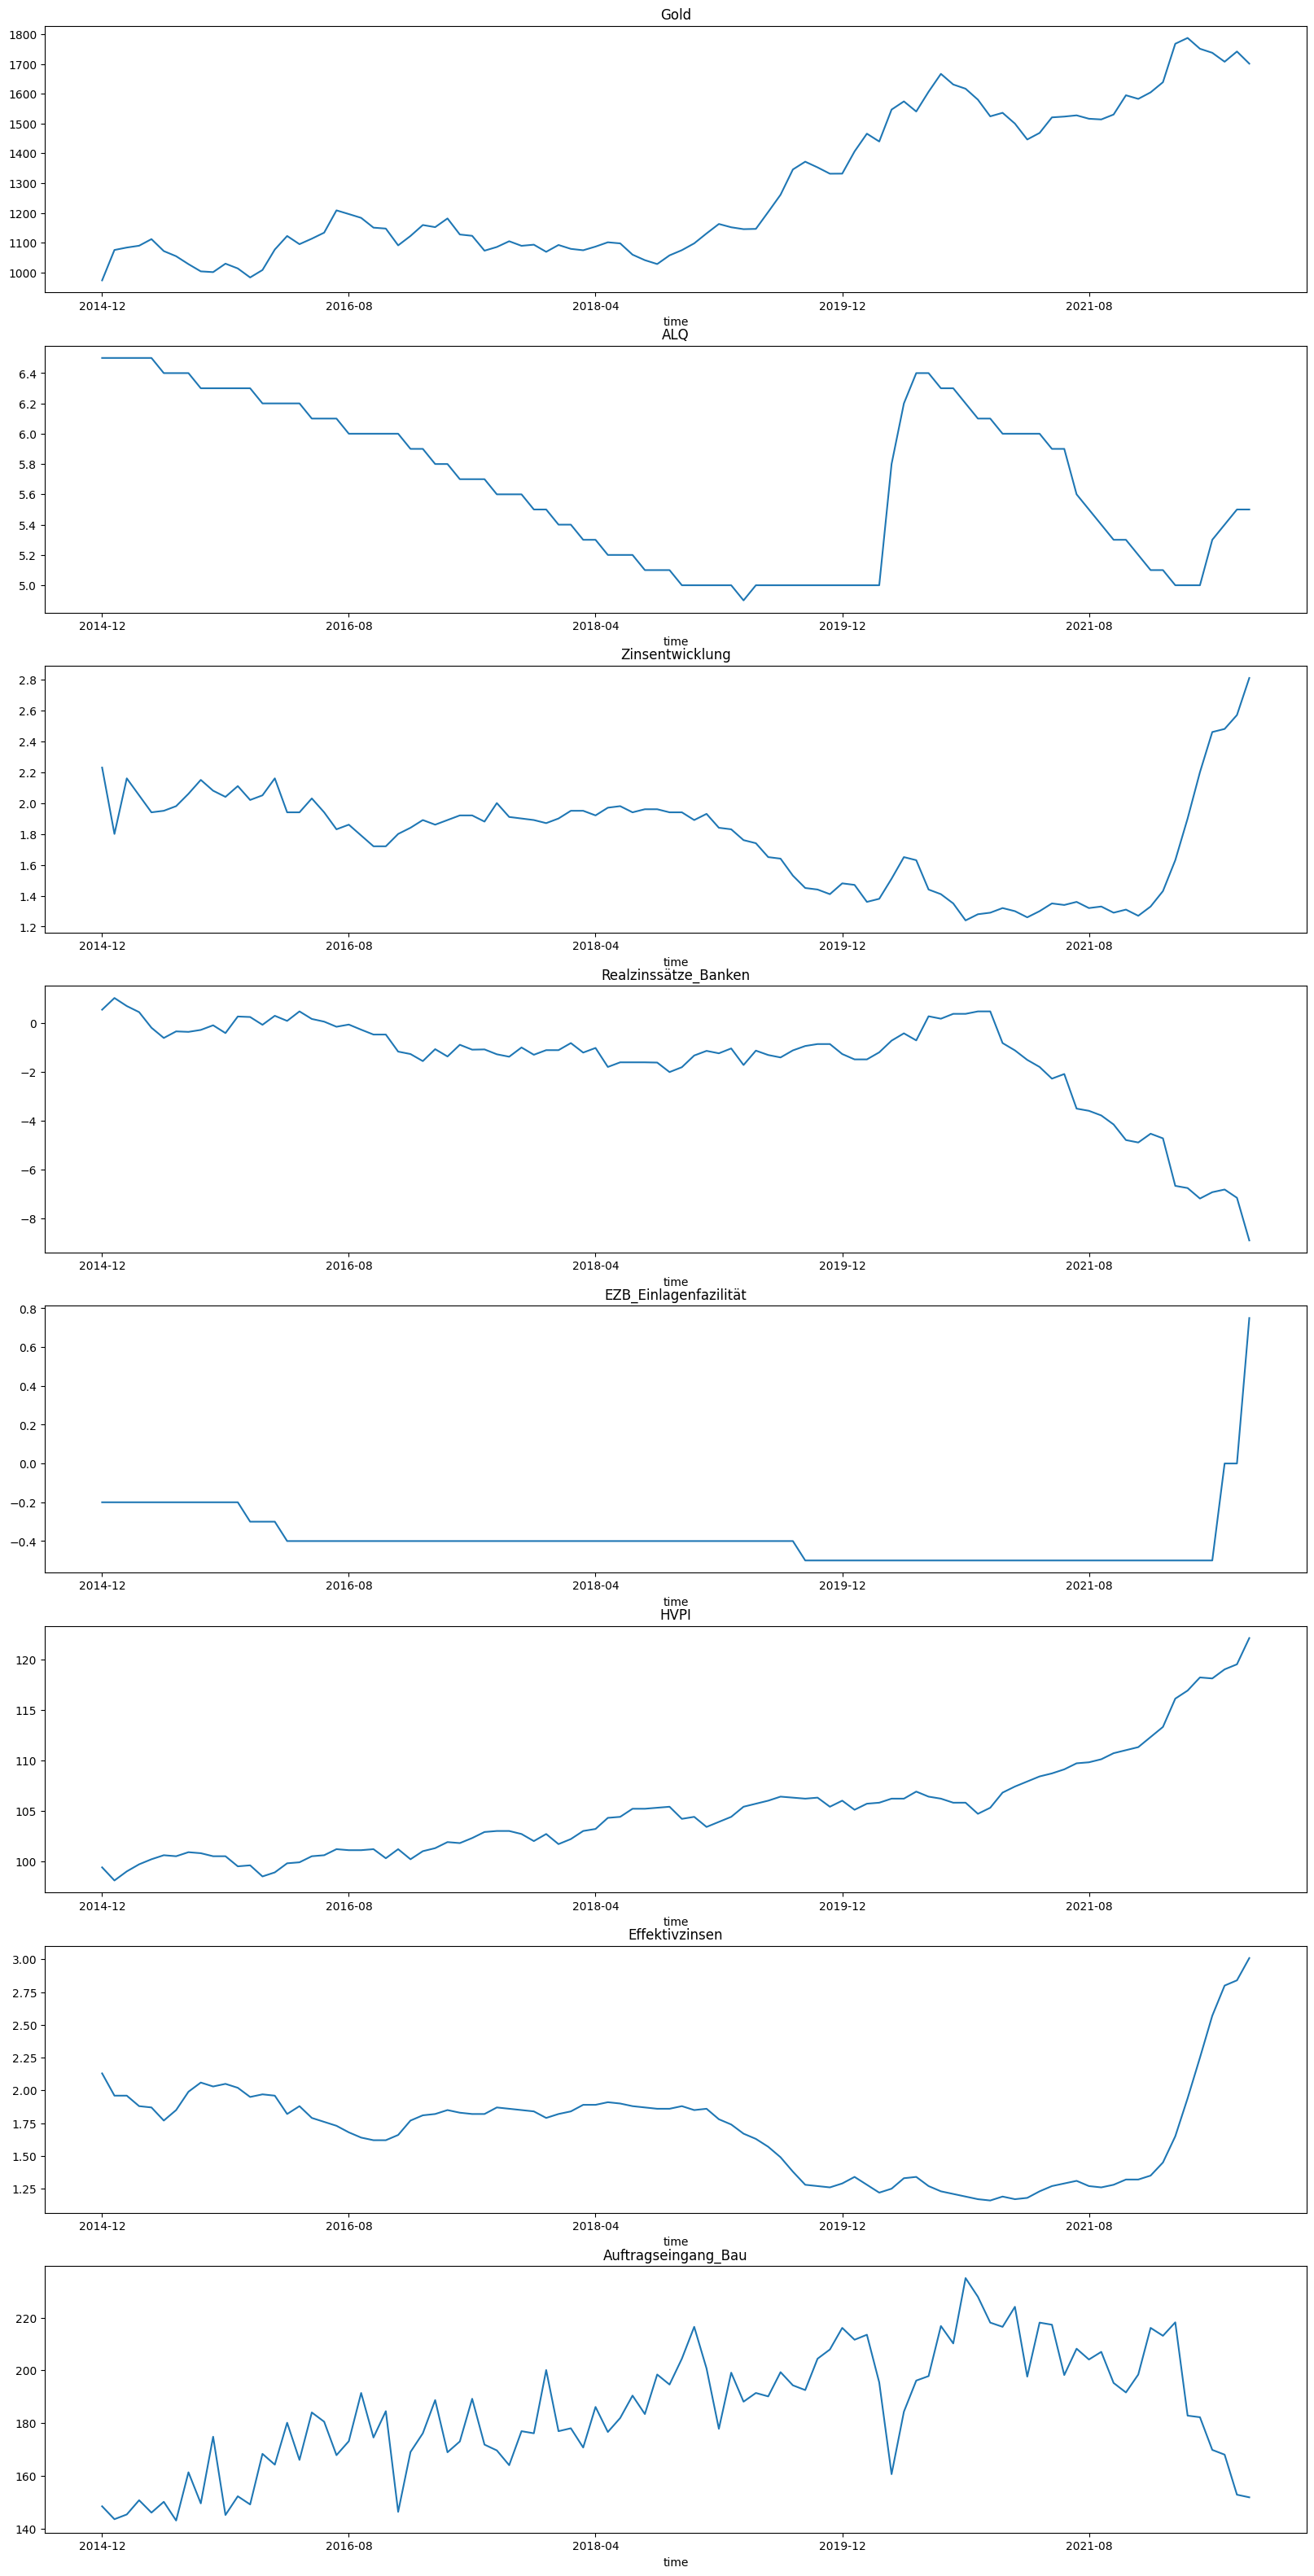

In [236]:
fig, axs = plt.subplots(len(DTF.columns), 1, figsize=(20, 40))

# Iterate over the columns of the dataframe
for i, col in enumerate(DTF.columns):
  # Plot each column in a separate subplot
  DTF[col].plot(ax=axs[i])
  # Set the title of the subplot
  axs[i].set_title(col)

# Show the plot
plt.show()